In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import random
import re
import spacy

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import gensim
from gensim import corpora, models, similarities, matutils
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
# logging (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
df = pd.read_csv('Copy of Uber Review Data.csv')
df

/home/ipsita/anaconda3/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


,Date,Stars,Comment
0,10/29/2019,1,I had an accident with an Uber driver in Mexic...
1,10/28/2019,1,I have had my account completely hacked to whe...
2,10/27/2019,1,I requested an 8 mile ride in Boston on a Satu...
3,10/27/2019,1,I've been driving off and on with the company ...
4,10/25/2019,1,Uber is overcharging for Toll fees. When In Fl...
...,...,...,...
2342,1/10/2014,2,everyone knows uber is fast but when you had ...
2343,12/18/2013,1,For a service that asks for your credit card n...
2344,12/18/2013,2,"great service, but hiring drivers who do not k..."
2345,5/13/2013,1,Uber has several problems that make it a poor ...


In [2]:
import sys
print(sys.executable)

/home/ipsita/anaconda3/bin/python


In [3]:
#df.describe()
print(gensim.__version__)

4.1.2


It appears that most people writing reviews in this dataset are those unhappy with Uber service. It will be useful for Uber to know which aspects their patrons are unhappy with so it could better streamline its effort to improve. 

In [4]:
#data cleaning
null_count = df.isnull().sum()
null_count

Date       0
Stars      0
Comment    0
dtype: int64

In [5]:
nan_count = df.isna().sum()
nan_count

Date       0
Stars      0
Comment    0
dtype: int64

In [6]:
df['Stars'].describe()

count    2347.000000
mean        1.686408
std         1.343291
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         5.000000
Name: Stars, dtype: float64

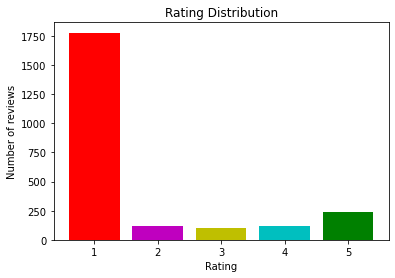

<Figure size 432x288 with 0 Axes>

In [7]:
#separating by groups
groups = df.groupby('Stars').count()
Values = groups.Comment
colors = ['r', 'm', 'y', 'c', 'g']
#making bar plot
plt.bar(([1,2,3,4,5]), Values, color= colors)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Number of reviews')
plt.show()
plt.savefig('stars.png')

As we found earlier, there is a disproportionately large number of negative reviews (1 star). We will start by removing all the neutral comments (3-stars) and representing the positive ratings (4 and 5 stars) as 1 and the negative ratings (1 and 2 stars) as 0. 

In [8]:
df = df[df.Stars != 3]
df['Target'] = np.where(df['Stars'] > 3, 1, 0)
df

/tmp/ipykernel_43213/3903686096.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Target'] = np.where(df['Stars'] > 3, 1, 0)


,Date,Stars,Comment,Target
0,10/29/2019,1,I had an accident with an Uber driver in Mexic...,0
1,10/28/2019,1,I have had my account completely hacked to whe...,0
2,10/27/2019,1,I requested an 8 mile ride in Boston on a Satu...,0
3,10/27/2019,1,I've been driving off and on with the company ...,0
4,10/25/2019,1,Uber is overcharging for Toll fees. When In Fl...,0
...,...,...,...,...
2342,1/10/2014,2,everyone knows uber is fast but when you had ...,0
2343,12/18/2013,1,For a service that asks for your credit card n...,0
2344,12/18/2013,2,"great service, but hiring drivers who do not k...",0
2345,5/13/2013,1,Uber has several problems that make it a poor ...,0


100 rows with 3 stars have dropped out. 

Next we will clean the document of punctuations, numbers, unicode
characters. 


In [9]:
df['Date'].describe

<bound method NDFrame.describe of 0       10/29/2019
1       10/28/2019
2       10/27/2019
3       10/27/2019
4       10/25/2019
           ...    
2342     1/10/2014
2343    12/18/2013
2344    12/18/2013
2345     5/13/2013
2346      5/8/2013
Name: Date, Length: 2247, dtype: object>

In [10]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'], df['Month'] = df['Date'].dt.year, df['Date'].dt.month
df

/tmp/ipykernel_43213/113307770.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])
/tmp/ipykernel_43213/113307770.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'], df['Month'] = df['Date'].dt.year, df['Date'].dt.month


,Date,Stars,Comment,Target,Year,Month
0,2019-10-29,1,I had an accident with an Uber driver in Mexic...,0,2019,10
1,2019-10-28,1,I have had my account completely hacked to whe...,0,2019,10
2,2019-10-27,1,I requested an 8 mile ride in Boston on a Satu...,0,2019,10
3,2019-10-27,1,I've been driving off and on with the company ...,0,2019,10
4,2019-10-25,1,Uber is overcharging for Toll fees. When In Fl...,0,2019,10
...,...,...,...,...,...,...
2342,2014-01-10,2,everyone knows uber is fast but when you had ...,0,2014,1
2343,2013-12-18,1,For a service that asks for your credit card n...,0,2013,12
2344,2013-12-18,2,"great service, but hiring drivers who do not k...",0,2013,12
2345,2013-05-13,1,Uber has several problems that make it a poor ...,0,2013,5


In [11]:
df['totalwords'] = [len(x.split()) for x in df['Comment'].tolist()]
df.head()

/tmp/ipykernel_43213/3336548919.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['totalwords'] = [len(x.split()) for x in df['Comment'].tolist()]


,Date,Stars,Comment,Target,Year,Month,totalwords
0,2019-10-29,1,I had an accident with an Uber driver in Mexic...,0,2019,10,153
1,2019-10-28,1,I have had my account completely hacked to whe...,0,2019,10,155
2,2019-10-27,1,I requested an 8 mile ride in Boston on a Satu...,0,2019,10,45
3,2019-10-27,1,I've been driving off and on with the company ...,0,2019,10,120
4,2019-10-25,1,Uber is overcharging for Toll fees. When In Fl...,0,2019,10,109


2021-11-12 07:22:52,572 : INFO : Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
2021-11-12 07:22:52,578 : INFO : Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
2021-11-12 07:22:52,581 : INFO : Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
2021-11-12 07:22:52,583 : INFO : Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
2021-11-12 07:22:52,583 : INFO : Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
2021-11-12 07:22:52,586 : INFO : Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


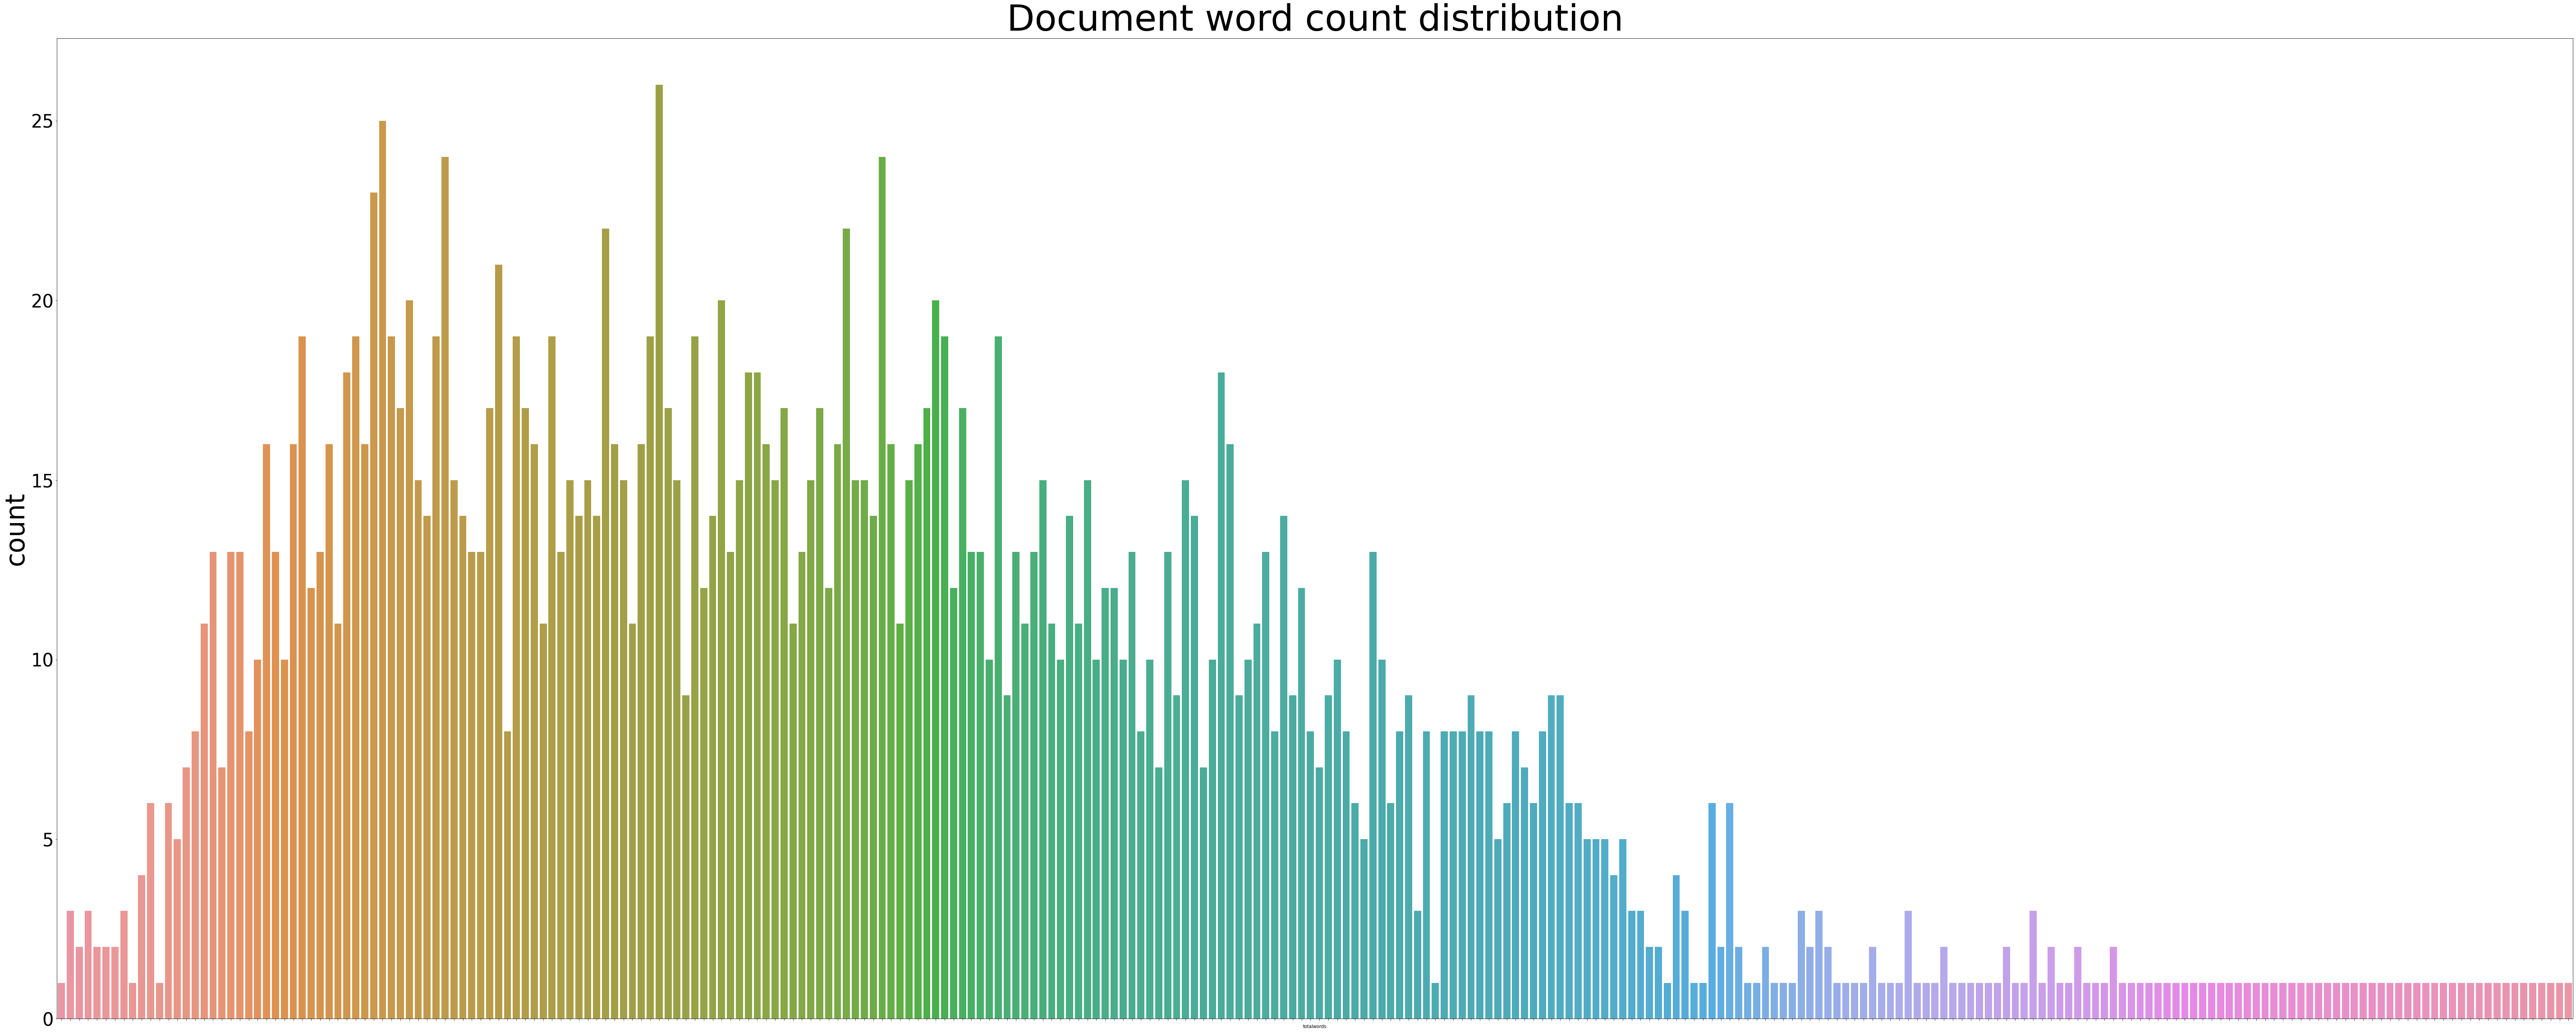

In [12]:
plt.rcParams["figure.figsize"] = (100, 40)
plt.xticks(fontsize=0)
plt.yticks(fontsize=40)
plt.title("Document word count distribution", fontsize=80)
#plt.xlabel("F score", fontsize=16)
plt.ylabel("Number of Documents", fontsize=58)
#ax.set_title("Feature importances using MDI")
#ax.set_ylabel("Mean decrease in impurity")
ax = sns.countplot(x="totalwords",data=df)

<AxesSubplot:>

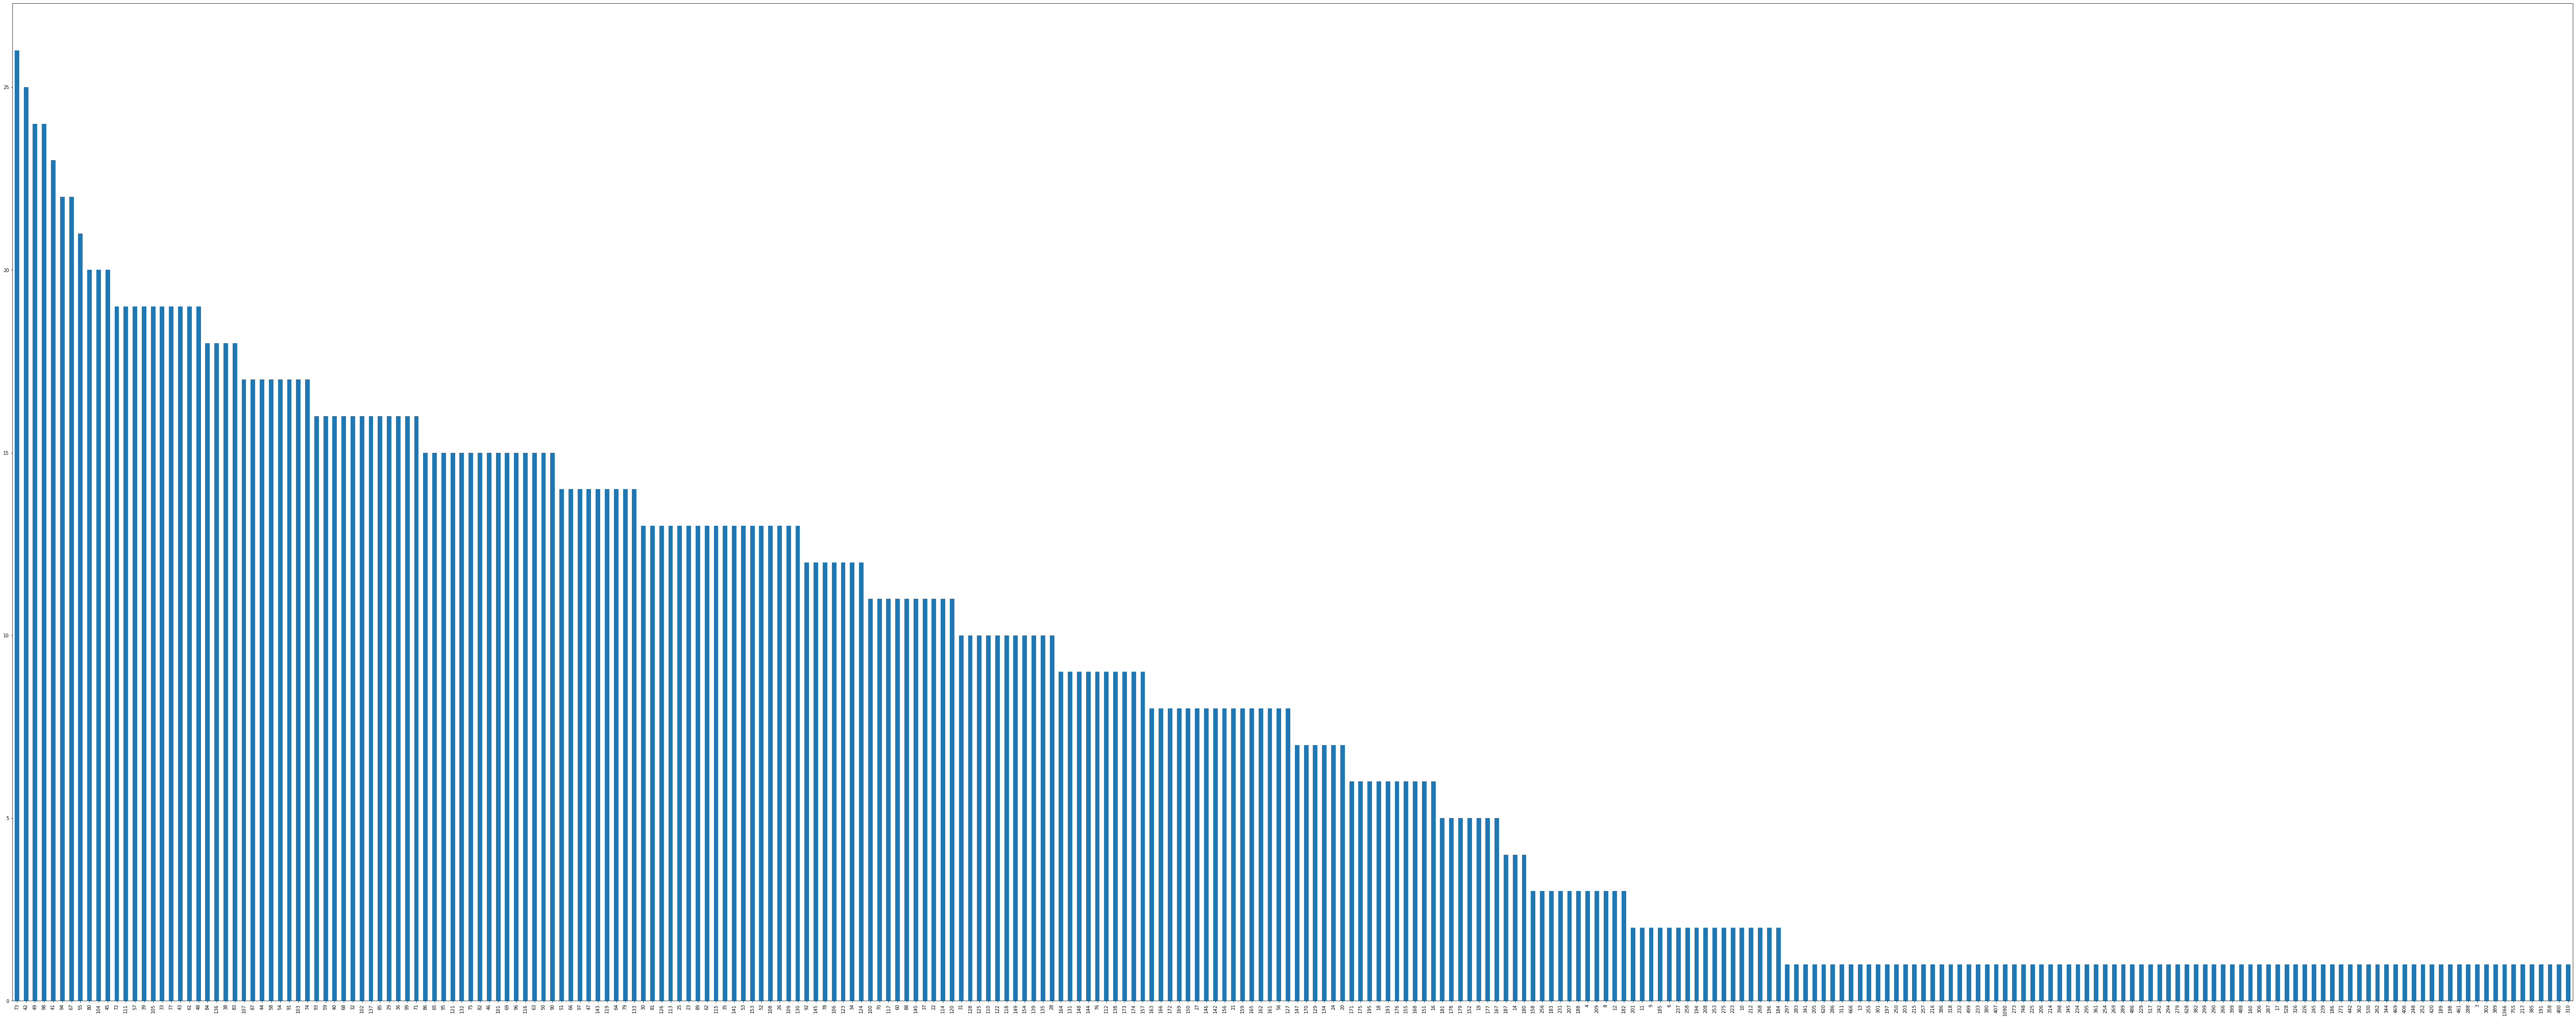

In [13]:
#data = load_my_data()
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (100, 7)
df['totalwords'].value_counts().plot(ax=ax, kind='bar')

In [14]:
df['totalwords'].describe()

count    2247.000000
mean      102.021807
std        76.882240
min         3.000000
25%        55.000000
50%        91.000000
75%       132.000000
max      1366.000000
Name: totalwords, dtype: float64

In [15]:
df1= df[df.Target != 1]
df1 = df[df.Year != 2013]
df1 = df[df.Year != 2014]
df1 = df[df.Year != 2015]
df1 = df[df.Year != 2016]
#data = data[data.injury_severity_name != 'Died Prior to Crash']
df1

,Date,Stars,Comment,Target,Year,Month,totalwords
0,2019-10-29,1,I had an accident with an Uber driver in Mexic...,0,2019,10,153
1,2019-10-28,1,I have had my account completely hacked to whe...,0,2019,10,155
2,2019-10-27,1,I requested an 8 mile ride in Boston on a Satu...,0,2019,10,45
3,2019-10-27,1,I've been driving off and on with the company ...,0,2019,10,120
4,2019-10-25,1,Uber is overcharging for Toll fees. When In Fl...,0,2019,10,109
...,...,...,...,...,...,...,...
2342,2014-01-10,2,everyone knows uber is fast but when you had ...,0,2014,1,49
2343,2013-12-18,1,For a service that asks for your credit card n...,0,2013,12,95
2344,2013-12-18,2,"great service, but hiring drivers who do not k...",0,2013,12,39
2345,2013-05-13,1,Uber has several problems that make it a poor ...,0,2013,5,193


# 'NewData.ipynb'

The subset of data with negative reviews only for the period 2017-2019 is analyzed in 
the file NewData.ipynb.  

In [16]:
df1.to_csv('new_negative.csv', index = False)

# Cleaning text data

Continuing with analysis of the complete dataset:

In [17]:
# import string

# def clean_text(s: str) -> str:
#     s = s.translate(str.maketrans('', '', string.punctuation))
#     s = " ".join(s.split())
#     s = s.lower()
#     return s

# assert clean_text("     ' #HELLO!!!! \n   ''") == 'hello'
# assert clean_text("     ’ #HELLO!!!! \n   ’")  == '’ hello ’' # Other punctuation-like characters that are not removed

In [18]:
# clean_text(df['Comment'])

In [19]:
# from nltk.tokenize import RegexpTokenizer
# whitespace_tokenizer = RegexpTokenizer("\s+", gaps=True)
# print(whitespace_tokenizer.tokenize(letters_only))

In [20]:
nlp = spacy.load('en_core_web_sm')
docs = list(nlp.pipe(df.Comment))
df['spacy_doc'] = docs

/tmp/ipykernel_43213/3330946083.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['spacy_doc'] = docs


In [21]:
# nlp = spacy.load("en")
# nlp.Defaults.stop_words.add("Uber")

In [22]:
docs_clean = [[w.lemma_.lower() for w in doc if (not w.is_stop and not w.is_punct and not w.like_num) or (w.lemma_=='not')] for doc in docs]
df['docs_clean'] = docs_clean

/tmp/ipykernel_43213/258732281.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['docs_clean'] = docs_clean


In [23]:
df.head()

,Date,Stars,Comment,Target,Year,Month,totalwords,spacy_doc,docs_clean
0,2019-10-29,1,I had an accident with an Uber driver in Mexic...,0,2019,10,153,"(I, had, an, accident, with, an, Uber, driver,...","[accident, uber, driver, mexico, city, car, ge..."
1,2019-10-28,1,I have had my account completely hacked to whe...,0,2019,10,155,"(I, have, had, my, account, completely, hacked...","[account, completely, hack, not, sign, view, s..."
2,2019-10-27,1,I requested an 8 mile ride in Boston on a Satu...,0,2019,10,45,"(I, requested, an, 8, mile, ride, in, Boston, ...","[request, mile, ride, boston, saturday, night,..."
3,2019-10-27,1,I've been driving off and on with the company ...,0,2019,10,120,"(I, 've, been, driving, off, and, on, with, th...","[drive, company, drive, new, place, notice, ub..."
4,2019-10-25,1,Uber is overcharging for Toll fees. When In Fl...,0,2019,10,109,"(Uber, is, overcharging, for, Toll, fees, ., W...","[uber, overcharge, toll, fee, florida, tolls, ..."


In [24]:
docs_list_clean = [' '.join(doc) for doc in docs_clean]
docs_list_clean[:-3]

['accident uber driver mexico city car get mirror brakes not work properly get accident twice driver conversation unpleasant foreigner curious ask bring mexico reply tourist conversation rude ask come look mexican husband answer keep quiet take wrong route request stop have mind uberx. continue ask sleep literally stop car ask wait text ask let different driver lock door allow',
 'account completely hack not sign view spend $ 1k uber ride credit debit card link account dial number available safety line tell need wait department email hear hour prompt message not help day receive phone helpful support email nightmare bad customer service experience go file police report person driver catch fraudulently account look attorney uber not make identity theft priority rectify situation end',
 'request mile ride boston saturday night 1:00 come $ app lyft rate end take regular cab cost $ beware high rate',
 'drive company drive new place notice uber take fare passenger pay $ uber take $ give $ d

In [25]:
# import ftfy
# ftfy.fix_text('âœ” â€œmessâ€\x9d No problems')
# unicode_clean = [ftfy.fix_text('âœ” No problems') for w in docs_clean] 
# unicode_clean

There are still numbers, unicode characters, an words such as 'Uber' that need further cleaning. 

In [26]:
letters_only = [re.sub("[^a-zA-Z]", " ", w)for w in docs_list_clean]
letters_only

['accident uber driver mexico city car get mirror brakes not work properly get accident twice driver conversation unpleasant foreigner curious ask bring mexico reply tourist conversation rude ask come look mexican husband answer keep quiet take wrong route request stop have mind uberx  continue ask sleep literally stop car ask wait text ask let different driver lock door allow',
 'account completely hack not sign view spend    k uber ride credit debit card link account dial number available safety line tell need wait department email hear hour prompt message not help day receive phone helpful support email nightmare bad customer service experience go file police report person driver catch fraudulently account look attorney uber not make identity theft priority rectify situation end',
 'request mile ride boston saturday night      come   app lyft rate end take regular cab cost   beware high rate',
 'drive company drive new place notice uber take fare passenger pay   uber take   give   d

This effectively got rid of the numbers and unicode characters.

In [27]:
# #Cleaning document of numbers
# numbers_clean = [re.sub(r"\b[0-9]+\b\s*", "", w) for w in docs_list_clean]
# numbers_clean

In [28]:
# nlp = spacy.load("en")
# nlp.Defaults.stop_words |= {"uber","x", "d"}
# #letters_clean = [w.lemma_.lower() for w in doc if not w.is_stop for doc in letters_only]
# letters_clean = [w.lemma_.lower() if (not w.is_stop) for w in letters_only]

In [29]:
vec = TfidfVectorizer(stop_words = 'english', max_df = 0.5, max_features = 1000)
X = vec.fit_transform(letters_only)
df_X = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
df_X.head()
#print(X.shape)

,able,absolutely,accept,access,accident,accord,account,acknowledge,action,active,...,worth,write,wrong,xl,year,yell,yellow,yes,yesterday,york
0,0.0,0.0,0.0,0.0,0.329335,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.115477,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.290682,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.100275,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
len(vec.get_feature_names())

1000

# Topic Modelling

In [31]:
num_topics = 4
#topics = TruncatedSVD(num_topics)
topics = NMF(num_topics)
doc_topic = topics.fit_transform(X)
#topics.explained_variance_ratio_

/home/ipsita/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [32]:
topic_word = pd.DataFrame(topics.components_.round(3),
             columns = vec.get_feature_names()).T.add_prefix('topic_')
topic_word

,topic_0,topic_1,topic_2,topic_3
able,0.054,0.076,0.000,0.075
absolutely,0.044,0.044,0.012,0.014
accept,0.026,0.048,0.054,0.078
access,0.000,0.067,0.000,0.008
accident,0.074,0.000,0.000,0.007
...,...,...,...,...
yell,0.042,0.000,0.000,0.009
yellow,0.069,0.000,0.010,0.021
yes,0.043,0.005,0.012,0.019
yesterday,0.030,0.015,0.017,0.034


In [33]:
#doc_topic = nmf.transform(topic_word)

In [34]:
doc_topic_df = pd.DataFrame(doc_topic).add_prefix('topic_').round(3)

doc_topic_df[['Comment']] = df[['Comment']]
doc_topic_df[['Target']] = df[['Target']]
doc_topic_df[['Year']] = df[['Year']]
doc_topic_df[['Month']] = df[['Month']]
doc_topic_df.head()

,topic_0,topic_1,topic_2,topic_3,Comment,Target,Year,Month
0,0.043,0.005,0.000,0.057,I had an accident with an Uber driver in Mexic...,0.0,2019.0,10.0
1,0.019,0.201,0.000,0.003,I have had my account completely hacked to whe...,0.0,2019.0,10.0
2,0.034,0.000,0.063,0.032,I requested an 8 mile ride in Boston on a Satu...,0.0,2019.0,10.0
3,0.123,0.000,0.011,0.000,I've been driving off and on with the company ...,0.0,2019.0,10.0
4,0.000,0.061,0.177,0.000,Uber is overcharging for Toll fees. When In Fl...,0.0,2019.0,10.0


In [35]:
doc_topic_df.sort_values(by='topic_2', ascending=False).head(10)

,topic_0,topic_1,topic_2,topic_3,Comment,Target,Year,Month
98,0.00,0.022,0.225,0.010,"Overall a very marvellous travelling facility,...",1.0,2019.0,5.0
403,0.00,0.000,0.219,0.000,I have had it where an Uber driver has cancele...,0.0,2019.0,1.0
1999,0.00,0.116,0.217,0.000,At about 11pm my friends and I ordered an uber...,0.0,2016.0,1.0
1362,0.00,0.000,0.212,0.012,As a transportation planner the Uber business ...,1.0,2017.0,5.0
2006,0.00,0.005,0.198,0.044,The founders and management of Uber have gotte...,0.0,2016.0,1.0
1692,0.00,0.030,0.195,0.018,I started driving for Uber when I saw an ad on...,0.0,2016.0,10.0
475,0.00,0.055,0.192,0.030,My automobile dealership has started using Ube...,0.0,2018.0,11.0
1857,0.00,0.000,0.192,0.131,I have travelled with ola cabs was never cheat...,0.0,2016.0,5.0
1259,0.01,0.000,0.189,0.004,Today I pick customer up but I wait the 4 minu...,0.0,2017.0,7.0
1263,0.00,0.000,0.188,0.067,"After a night out one weekend, a friend called...",0.0,2017.0,7.0


In [36]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [37]:
display_topics(topics, vec.get_feature_names(), 10)


Topic  0
car, drive, time, service, use, pay, like, good, experience, rider

Topic  1
card, account, credit, email, phone, customer, number, service, contact, support

Topic  2
charge, ride, trip, fee, fare, price, mile, cost, surge, quote

Topic  3
cancel, minute, say, wait, order, pick, ride, away, come, min


These are the initial topic models. While the second topic seems to be connected with technology, the third with fare amount, and the fourth with service (waiting, cancellation etc.), the first topic is not so apparent. Next we will try to interpret Topic 0.

In [38]:
for i in doc_topic_df.sort_values(by='topic_0', ascending=False).head(10)['Comment'].values:
    print(i)
    print()

I have a worst experience in UBER. Most Cheated company, worst drivers, rash driving. Never ever think to book this cab.  I am not getting the option of negative rating.

Drivers were nice and receptive to directions and much cheaper than a taxi! If you wanna try Uber for free use promo code RACHILLRUE and your first ride is on me!

Worst experience I have ever had with customer service, and being screwed over with my money, and my time. With uber taking up to 25% of fare (which I am ok with and agreed to) They should by far be able to hire a few people to answer phones and solve problems. The fares randomly change with no explanation and no response from suppprt. A $25 far turns to a $20 fare out of thin air, and then on top of the missing $5 uber takes its 25%. Great idea and easy app, but many bugs and zero customer support to fix the issues. Just my though, but I was under the impression that the uber fee was for using their technology. Seems to me they need to take a little bit of

Topic_0 seems to be about the experience, both good and bad. I would next like to model topics by positive or negative rating and by years. 

In [39]:
topic_word.sort_values(by='topic_1', ascending=False).head(10)

,topic_0,topic_1,topic_2,topic_3
card,0.000,0.954,0.001,0.000
account,0.000,0.931,0.000,0.000
credit,0.000,0.613,0.065,0.000
email,0.007,0.554,0.000,0.045
phone,0.066,0.437,0.000,0.198
customer,0.331,0.403,0.004,0.122
number,0.000,0.390,0.000,0.071
service,0.640,0.365,0.000,0.044
contact,0.035,0.311,0.030,0.171
support,0.063,0.311,0.000,0.000


Yes, it is the overall experience.

In [40]:
#doc_topic_df.groupby('Target', np.mean)
doc_topic_df.groupby('Target', as_index=False)['topic_0'].mean()

,Target,topic_0
0,0.0,0.036406
1,1.0,0.042099


In [41]:
doc_topic_df.groupby('Target', as_index=False)['topic_1'].mean()

,Target,topic_1
0,0.0,0.035463
1,1.0,0.031420


In [42]:
doc_topic_df.groupby('Target', as_index=False)['topic_2'].mean()

,Target,topic_2
0,0.0,0.033233
1,1.0,0.030863


In [43]:
doc_topic_df.groupby('Target', as_index=False)['topic_3'].mean()

,Target,topic_3
0,0.0,0.033047
1,1.0,0.028708


In [44]:
doc_topic_df.groupby(['Year', 'Target'], as_index=False)['topic_0'].mean()

,Year,Target,topic_0
0,2015.0,0.0,0.045422
1,2015.0,1.0,0.048125
2,2016.0,0.0,0.039536
3,2016.0,1.0,0.047900
4,2017.0,0.0,0.034332
5,2017.0,1.0,0.040308
6,2018.0,0.0,0.032159
7,2018.0,1.0,0.039529
8,2019.0,0.0,0.036529
9,2019.0,1.0,0.043356


In [45]:
doc_topic_df.groupby(['Year', 'Target'], as_index=False)['topic_1'].mean()

,Year,Target,topic_1
0,2015.0,0.0,0.030765
1,2015.0,1.0,0.039750
2,2016.0,0.0,0.028567
3,2016.0,1.0,0.023167
4,2017.0,0.0,0.034535
5,2017.0,1.0,0.034103
6,2018.0,0.0,0.040628
7,2018.0,1.0,0.032294
8,2019.0,0.0,0.041256
9,2019.0,1.0,0.027506


In [46]:
doc_topic_df.groupby(['Year', 'Target'], as_index=False)['topic_2'].mean()

,Year,Target,topic_2
0,2015.0,0.0,0.030406
1,2015.0,1.0,0.038583
2,2016.0,0.0,0.036290
3,2016.0,1.0,0.043200
4,2017.0,0.0,0.033387
5,2017.0,1.0,0.027906
6,2018.0,0.0,0.033651
7,2018.0,1.0,0.031306
8,2019.0,0.0,0.030236
9,2019.0,1.0,0.028023


In [47]:
doc_topic_df.groupby(['Year', 'Target'], as_index=False)['topic_3'].mean()

,Year,Target,topic_3
0,2015.0,0.0,0.019000
1,2015.0,1.0,0.016917
2,2016.0,0.0,0.029792
3,2016.0,1.0,0.024100
4,2017.0,0.0,0.039762
5,2017.0,1.0,0.034068
6,2018.0,0.0,0.039014
7,2018.0,1.0,0.026176
8,2019.0,0.0,0.025731
9,2019.0,1.0,0.028816


In [48]:
#import matplotlib.pyplot as plt
# fig=plt.figure(figsize=(10,10))
# ax1=fig.add_subplot(221)
#sns.barplot(x=df.index, y=df[['Weight', 'Variance']], ax=ax1)
df2 = pd.DataFrame({
    'Year': ['2013', '2014','2015', '2016', '2017', '2018', '2019'],
    'Negative': [0, 0, 0.019, 0.030, 0.040, 0.040, 0.026],
    'Positive': [0, 0, 0.017, 0.024, 0.034, 0.026, 0.029]
})
# #fig, ax1 = pyplot.subplots(figsize=(10, 10))
# fig, ax1 = subplot(figsize=(10, 10))
# tidy = df.melt(id_vars='Year').rename(columns=str.title)
# sns.barplot(x='Year', y='Value', hue='Variable', data=tidy, ax=ax1)
# sns.despine(fig)

#df2 = sns.load_dataset("df2")
sns.catplot(x="Year", y="Topic Scores", hue="Target", kind="bar", data=df2)

ValueError: Could not interpret input 'Topic Scores'

In [ ]:
#create_wordcloud(noun_pos)

In [ ]:
#create_wordcloud(noun_pos)

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(#stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

#topics = lda_model.show_topics(formatted=False)
topics = display_topics(topics, vec.get_feature_names(), 10)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


In [ ]:
#pip install textacy

In [ ]:
#textacy.viz.termite.termite_df_plot(components, *, highlight_topics=None, n_terms=25, rank_terms_by='max', sort_terms_by='seriation', save=False, rc_params=None)

In [ ]:
import textacy
#from textacy.vsm import Vectorizer
model = textacy.tm.TopicModel('nmf', n_topics=20)
model.termite_plot(topic_word, vectorizer.id_to_term, topics=-1,  n_terms=25, sort_terms_by='seriation')         
#textacy.termite_plot(topic_word, vectorizer.id_to_term, topics=-1,  n_terms=25, sort_terms_by='seriation')       


# Sentiment Analysis

In [ ]:
positive_reviews = df[df.Target==1]
negative_reviews = df[df.Target==0]

In [ ]:
pos_adj = [token.text.lower() for doc in positive_reviews.spacy_doc for token in doc if token.pos_=='ADJ']
neg_adj = [token.text.lower() for doc in negative_reviews.spacy_doc for token in doc if token.pos_=='ADJ']

pos_noun = [token.text.lower() for doc in positive_reviews.spacy_doc for token in doc if token.pos_=='NOUN']
neg_noun = [token.text.lower() for doc in negative_reviews.spacy_doc for token in doc if token.pos_=='NOUN']

In [ ]:
from collections import Counter

In [ ]:
adj_pos = Counter(pos_adj).most_common(10)

In [ ]:
adj_neg = Counter(neg_adj).most_common(10)

In [ ]:
noun_pos = Counter(pos_noun).most_common(10)

In [ ]:
noun_neg = Counter(neg_noun).most_common(10)

In [ ]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
def create_wordcloud(wordcloud_series):
    df_text = ' '.join(str(wordcloud_series).lower() for v in wordcloud_series)
    wordcloud = WordCloud(stopwords = None, random_state = 20, background_color = 'black',
                      collocations=True).generate(df_text)
    plt.imshow(wordcloud, interpolation='bilInear')
    plt.axis('off')
    plt.show()
    #plt.savefig('wordcloud.png')

In [ ]:
create_wordcloud(adj_pos)
plt.savefig('posadj.png')

In [ ]:
create_wordcloud(adj_neg)
plt.savefig('negadj.png')

In [ ]:
create_wordcloud(noun_pos)
plt.savefig('posnoun.png')

In [ ]:
create_wordcloud(noun_neg)
plt.savefig('negnoun.png')

The nouns are almost identical for positive and negative sentiments. 

# LDA

In [ ]:
vec1 = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
X_LDA = vec1.fit_transform(letters_only)
print(X_LDA.shape)

In [ ]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tf.fit(X_LDA)

In [ ]:
#lda_tf.print_topics()
#!pip install pyLDAvis

In [ ]:
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# pyLDAvis.enable_notebook()

# # feed the LDA model into the pyLDAvis instance
# #lda_viz = gensimvis.sklearn.prepare(lda_tf, X_LDA, vec1)
# lda_viz = pyLDAvis.gensim_models.prepare(lda_tf, X_LDA, vec1)

In [ ]:
corpus = matutils.Sparse2Corpus(X_LDA.T)

In [ ]:
id2word = dict((v, k) for k, v in vec1.vocabulary_.items())

In [ ]:
len(id2word)

In [ ]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=4, id2word=id2word, passes=5)

In [ ]:
lda.print_topics()

The LDA topics are less clear. 

In [ ]:
#!conda install pyLDAvis


pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
#lda_viz = gensimvis.sklearn.prepare(lda, corpus, id2word)
lda_viz = pyLDAvis.gensim_models.prepare(lda, corpus, id2word)